In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,classification_report

## Store Data into DataFrame

In [2]:
data_dir = '/kaggle/input/militaryaircraftdetectiondataset/crop'

filepaths = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        
        filepaths.append(fpath)
        labels.append(fold)
        

data_dir = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
data_dir


,filepaths,labels
0,/kaggle/input/militaryaircraftdetectiondataset...,CL415
1,/kaggle/input/militaryaircraftdetectiondataset...,CL415
2,/kaggle/input/militaryaircraftdetectiondataset...,CL415
3,/kaggle/input/militaryaircraftdetectiondataset...,CL415
4,/kaggle/input/militaryaircraftdetectiondataset...,CL415
...,...,...
31912,/kaggle/input/militaryaircraftdetectiondataset...,J10
31913,/kaggle/input/militaryaircraftdetectiondataset...,J10
31914,/kaggle/input/militaryaircraftdetectiondataset...,J10
31915,/kaggle/input/militaryaircraftdetectiondataset...,J10


## Splitting

In [3]:
valid_df,test_df = train_test_split(data_dir, test_size= 0.2, shuffle= True, random_state= 42)

# Model Structure

In [4]:
gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
                                   color_mode='rgb', class_mode='categorical', batch_size=16)

test_gen = gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
                                   color_mode='rgb', class_mode='categorical', batch_size=16)

Found 25533 validated image filenames belonging to 74 classes.
Found 25533 validated image filenames belonging to 74 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential

# Load EfficientNetB3 as base model
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="max"
)

# Build the model
model = Sequential([
    base_model,
    BatchNormalization(),
    
    # Add a Dense layer with Batch Normalization and Dropout
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    
    Dense(74, activation='softmax')  # 74 classes
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [6]:
history=model.fit(train_gen,validation_data=test_gen,epochs=20)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730753400.839318      98 service.cc:145] XLA service 0x7bbd4c006000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730753400.839365      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730753487.754945      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1596/1596 ━━━━━━━━━━━━━━━━━━━━ 552s 258ms/step - accuracy: 0.2659 - loss: 6.3993 - val_accuracy: 0.8082 - val_loss: 1.8294
Epoch 2/20
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 317s 197ms/step - accuracy: 0.7440 - loss: 1.8227 - val_accuracy: 0.9234 - val_loss: 0.7188
Epoch 3/20
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 313s 196ms/step - accuracy: 0.8694 - loss: 0.8673 - val_accuracy: 0.9662 - val_loss: 0.4081
Epoch 4/20
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 313s 196ms/step - accuracy: 0.9231 - loss: 0.5489 - val_accuracy: 0.9862 - val_loss: 0.2833
Epoch 5/20
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 316s 198ms/step - accuracy: 0.9472 - loss: 0.4067 - val_accuracy: 0.9928 - val_loss: 0.2116
Epoch 6/20
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 315s 197ms/step - accuracy: 0.9661 - loss: 0.3047 - val_accuracy: 0.9955 - val_loss: 0.1773
Epoch 7/20
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 313s 196ms/step - accuracy: 0.9701 - loss: 0.2589 - val_accuracy: 0.9974 - val_loss: 0.1495
Epoch 8/20
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 316s 198ms/step - accuracy: 0.9

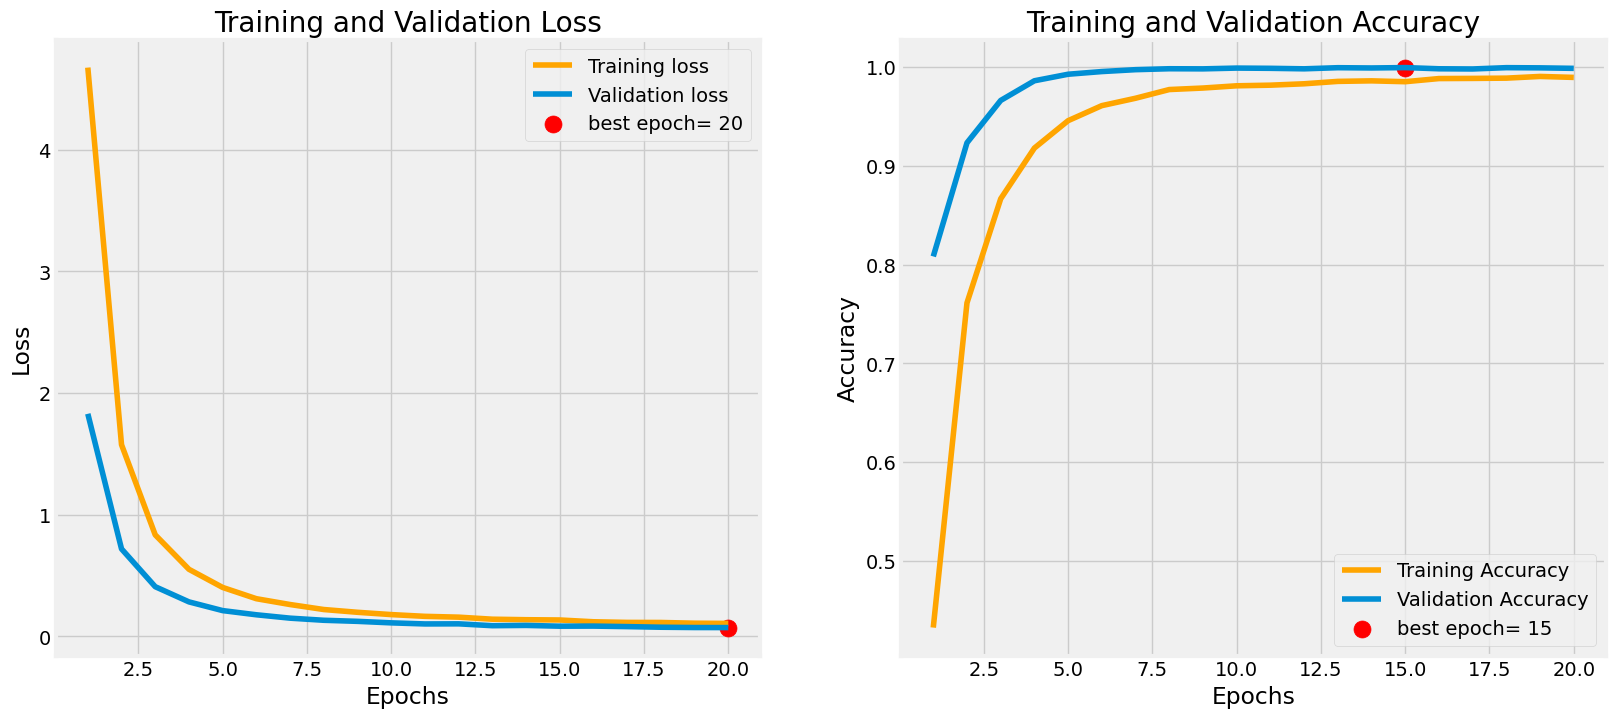

In [7]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'orange', label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'red', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'orange', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [21]:
train_score = model.evaluate(train_gen)
test_score = model.evaluate(test_gen)
# test_score = model.evaluate(test_gen)

pd.DataFrame({
    '': ['Loss','Accuracy'],
    'Train score': [train_score[0], f'{round(train_score[1] * 100, 2)}%'],
#     'Valid score': [valid_score[0], f'{round(valid_score[1] * 100, 2)}%']
    'Test score': [test_score[0], f'{round(test_score[1] * 100, 2)}%']})

1596/1596 ━━━━━━━━━━━━━━━━━━━━ 109s 68ms/step - accuracy: 0.9989 - loss: 0.0716
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 110s 69ms/step - accuracy: 0.9990 - loss: 0.0714


,,Train score,Test score
0,Loss,0.072011,0.072011
1,Accuracy,99.87%,99.87%


- **Accuracy 99.9%**